1.Configuración del ambiente

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import yfinance as yf
from bs4 import BeautifulSoup
import requests
from IPython.display import clear_output
import datetime 
import pytz

2.Obtención de Datos

Precios históricos del bitcoin

In [3]:
# La biblioteca yfinance de Python permite extraer datos financieros de Yahoo Finance.

def importar_base_bitcoin():
  global df_bitcoin
  data = yf.Ticker("BTC-USD").history(period='7d', interval='5m')
  df_bitcoin = pd.DataFrame(data)
  return df_bitcoin

importar_base_bitcoin()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Datetime,,,,,,,
2023-10-16 00:00:00+00:00,27162.628906,27172.263672,27150.240234,27172.263672,0,0.0,0.0
2023-10-16 00:05:00+00:00,27170.353516,27193.248047,27170.353516,27193.248047,25181696,0.0,0.0
2023-10-16 00:10:00+00:00,27193.240234,27198.468750,27175.326172,27175.326172,28948480,0.0,0.0
2023-10-16 00:15:00+00:00,27169.886719,27170.625000,27148.345703,27148.345703,27666944,0.0,0.0
2023-10-16 00:20:00+00:00,27147.185547,27160.308594,27147.185547,27160.308594,9837568,0.0,0.0
...,...,...,...,...,...,...,...
2023-10-22 04:25:00+00:00,29960.714844,29962.712891,29958.447266,29962.712891,20340736,0.0,0.0
2023-10-22 04:30:00+00:00,29960.726562,29960.726562,29957.048828,29957.642578,14379008,0.0,0.0
2023-10-22 04:35:00+00:00,29965.117188,29984.054688,29965.117188,29984.054688,19280896,0.0,0.0


Indicadores de tendencias

In [4]:
def extraer_tendencias():
    global precio_actual,tendencia
    url = 'https://coinmarketcap.com/'
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'lxml')
    precio_btc = soup.find('div', class_='sc-a0353bbc-0 gDrtaY').get_text()
    precio_btc = precio_btc.replace(',', '')
    precio_btc = precio_btc.replace('$', '')
    precio_actual = float(precio_btc)
    icon = soup.findAll('span', {'class':['sc-d55c02b-0 iwhBxy','sc-97d6d2ca-0 bQjSqS']})[0]
    if 'sc-d55c02b-0 iwhBxy' in ' '.join(icon['class']):
        tendencia = 'alta'
    else:
        tendencia = 'baja'
    variacion = soup.find('span', class_='sc-d55c02b-0 iwhBxy').get_text()
    return [precio_actual, tendencia, variacion]

extraer_tendencias()

[29984.6, 'alta', '0.22%']

3.Limpieza de datos

In [5]:
def limpieza_datos():
  global media_bitcoin,df_bitcoin_limpio
  df = importar_base_bitcoin()
  df_bitcoin_limpio = df.copy()
  indices_unicos = df_bitcoin_limpio.index.drop_duplicates()
  df_bitcoin_limpio = df_bitcoin_limpio.reindex(indices_unicos)
  df_bitcoin_limpio.dropna(subset = ['Close'], inplace = True)
  df_bitcoin_limpio = df_bitcoin_limpio[df_bitcoin_limpio['Volume'] > 0]
  close = df_bitcoin_limpio['Close']
  Q1 = close.quantile(.25)
  Q3 = close.quantile(.75)
  IIQ = Q3 - Q1
  limite_inferior = Q1 - 1.5 * IIQ
  limite_superior = Q3 + 1.5 * IIQ
  seleccion = ((close >= Q1) & (close < Q3))
  df_bitcoin_limpio = df_bitcoin_limpio[seleccion]

  return [df_bitcoin_limpio, Q1, Q3]

limpieza_datos()

[                                   Open          High           Low  \
 Datetime                                                              
 2023-10-16 13:25:00+00:00  27962.513672  28870.552734  27962.513672   
 2023-10-16 13:35:00+00:00  29253.310547  29253.310547  28769.916016   
 2023-10-16 14:30:00+00:00  28216.626953  28372.281250  28216.626953   
 2023-10-16 18:00:00+00:00  28244.125000  28353.457031  28244.125000   
 2023-10-16 18:05:00+00:00  28296.646484  28326.097656  28278.099609   
 ...                                 ...           ...           ...   
 2023-10-20 07:30:00+00:00  29257.257812  29277.507812  29256.732422   
 2023-10-20 07:35:00+00:00  29287.296875  29302.869141  29284.912109   
 2023-10-20 07:50:00+00:00  29337.167969  29337.167969  29284.687500   
 2023-10-20 07:55:00+00:00  29276.947266  29276.947266  29247.095703   
 2023-10-20 08:00:00+00:00  29257.906250  29283.953125  29257.906250   
 
                                   Close      Volume  Dividend

In [6]:
df_new = pd.DataFrame(df_bitcoin_limpio)

In [7]:
df_new

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Datetime,,,,,,,
2023-10-16 13:25:00+00:00,27962.513672,28870.552734,27962.513672,28870.552734,770936832,0.0,0.0
2023-10-16 13:35:00+00:00,29253.310547,29253.310547,28769.916016,29025.212891,2050228224,0.0,0.0
2023-10-16 14:30:00+00:00,28216.626953,28372.281250,28216.626953,28324.595703,210722816,0.0,0.0
2023-10-16 18:00:00+00:00,28244.125000,28353.457031,28244.125000,28305.324219,59832320,0.0,0.0
2023-10-16 18:05:00+00:00,28296.646484,28326.097656,28278.099609,28326.097656,104247296,0.0,0.0
...,...,...,...,...,...,...,...
2023-10-20 07:30:00+00:00,29257.257812,29277.507812,29256.732422,29277.507812,21073920,0.0,0.0
2023-10-20 07:35:00+00:00,29287.296875,29302.869141,29284.912109,29302.597656,13787136,0.0,0.0
2023-10-20 07:50:00+00:00,29337.167969,29337.167969,29284.687500,29284.687500,104130560,0.0,0.0


In [8]:
sns.set(style="darkgrid")

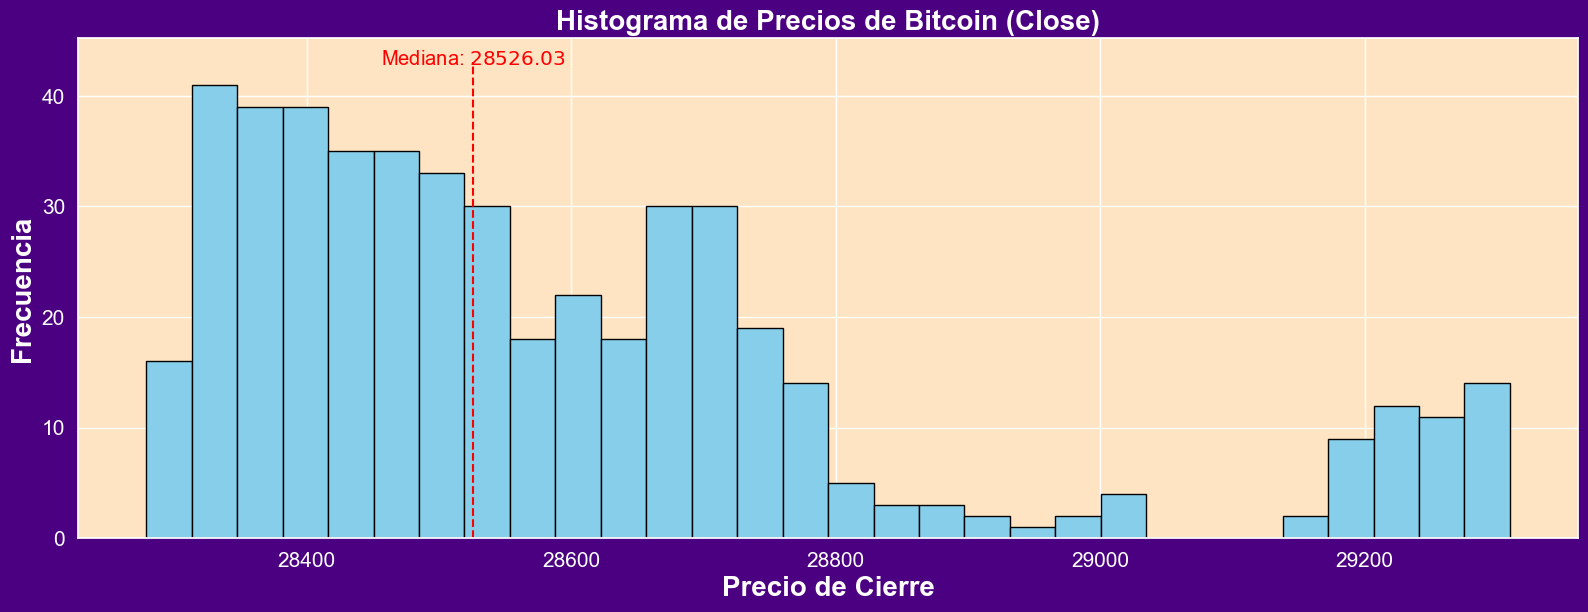

In [9]:
fig = plt.figure(figsize=(15, 5), facecolor='indigo')
eje = fig.add_axes([0, 0, 1, 1])
datos_limpios = limpieza_datos()[0]
close = datos_limpios['Close']
eje.hist(close, bins=30, color='skyblue', edgecolor='black')
# eje.grid(True, color='gray', linestyle='--')
mediana = close.median()
eje.vlines(x=mediana, ymin=0, ymax=eje.get_ylim()[1], color='red', linestyle='dashed', label='Mediana')
eje.set_title('Histograma de Precios de Bitcoin (Close)', fontsize=20, fontweight='bold', color='w')
eje.set_xlabel('Precio de Cierre', fontsize=20, fontweight='bold', color='w')
eje.set_ylabel('Frecuencia', fontsize=20, fontweight='bold', color='w')
eje.set_facecolor('bisque')
eje.tick_params(axis='x', colors='w', labelsize=15)
eje.tick_params(axis='y', colors='w', labelsize=15)
eje.annotate('Mediana: ${0:.2f}$'.format(mediana), xy=(mediana, eje.get_ylim()[1]-1.05), ha='center', va='top', color='red', fontsize=14.5)
plt.gray()
plt.show()

In [10]:
datos_limpios.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Datetime,,,,,,,
2023-10-16 13:25:00+00:00,27962.513672,28870.552734,27962.513672,28870.552734,770936832,0.0,0.0
2023-10-16 13:35:00+00:00,29253.310547,29253.310547,28769.916016,29025.212891,2050228224,0.0,0.0
2023-10-16 14:30:00+00:00,28216.626953,28372.281250,28216.626953,28324.595703,210722816,0.0,0.0
2023-10-16 18:00:00+00:00,28244.125000,28353.457031,28244.125000,28305.324219,59832320,0.0,0.0
2023-10-16 18:05:00+00:00,28296.646484,28326.097656,28278.099609,28326.097656,104247296,0.0,0.0


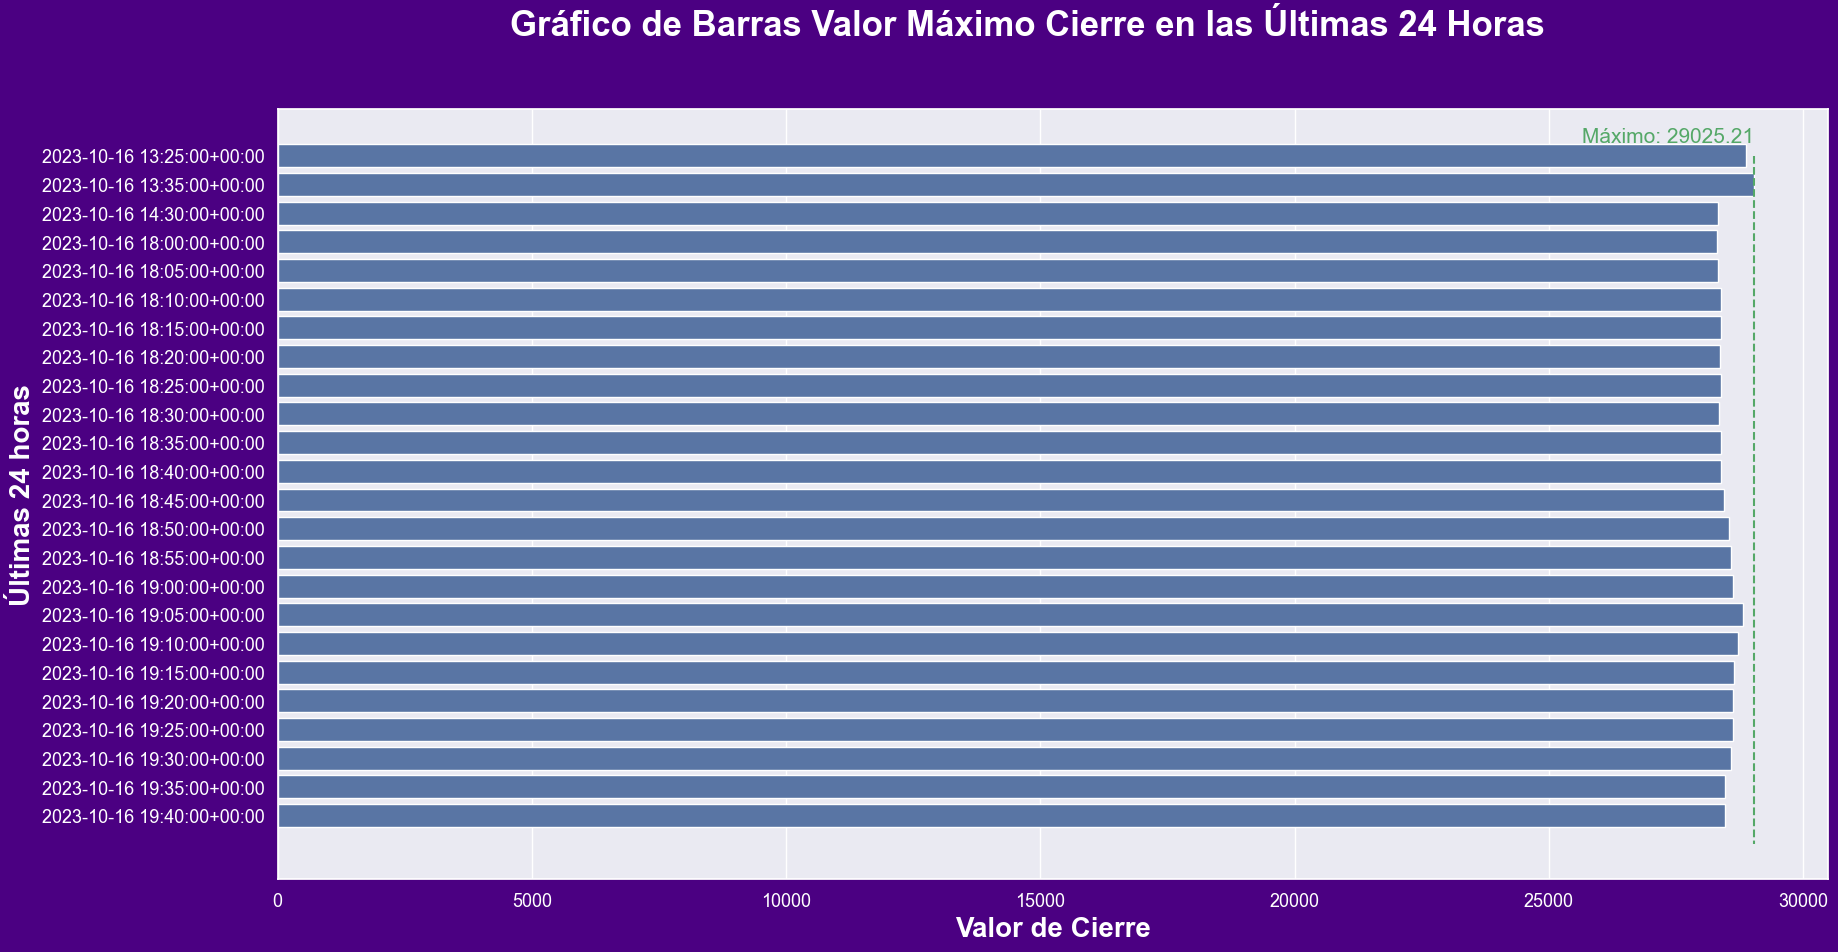

In [11]:
plt.figure(figsize=(20, 10), facecolor='indigo')
datos_limpios = limpieza_datos()[0]
close = datos_limpios['Close']
sns.barplot( data=datos_limpios.head(24), x='Close', y='Datetime');
plt.suptitle('Gráfico de Barras Valor Máximo Cierre en las Últimas 24 Horas', color='w', fontsize=25, fontweight='bold')
plt.xlabel('Valor de Cierre',color='w', size=20, fontweight='bold')
plt.ylabel('Últimas 24 horas', color='w', size=20, fontweight='bold')
plt.tick_params(axis='x', colors='w', labelsize=13)
plt.tick_params(axis='y', colors='w',labelsize=13)
maximos = round(datos_limpios.head(24)[datos_limpios.head(24)['Close'] == datos_limpios.head(24)['Close'].max()], 2)
plt.vlines(x=maximos['Close'], ymin=0, ymax=len(datos_limpios.head(24)), colors='g', linestyles='dashed', label='Máximo')
for index, row in maximos.iterrows():
    plt.text(row['Close'], len(datos_limpios.head(24)) - 25, f'Máximo: {row["Close"]}', fontsize=15, ha='right', va='top', color='g')
plt.gray()
plt.show()

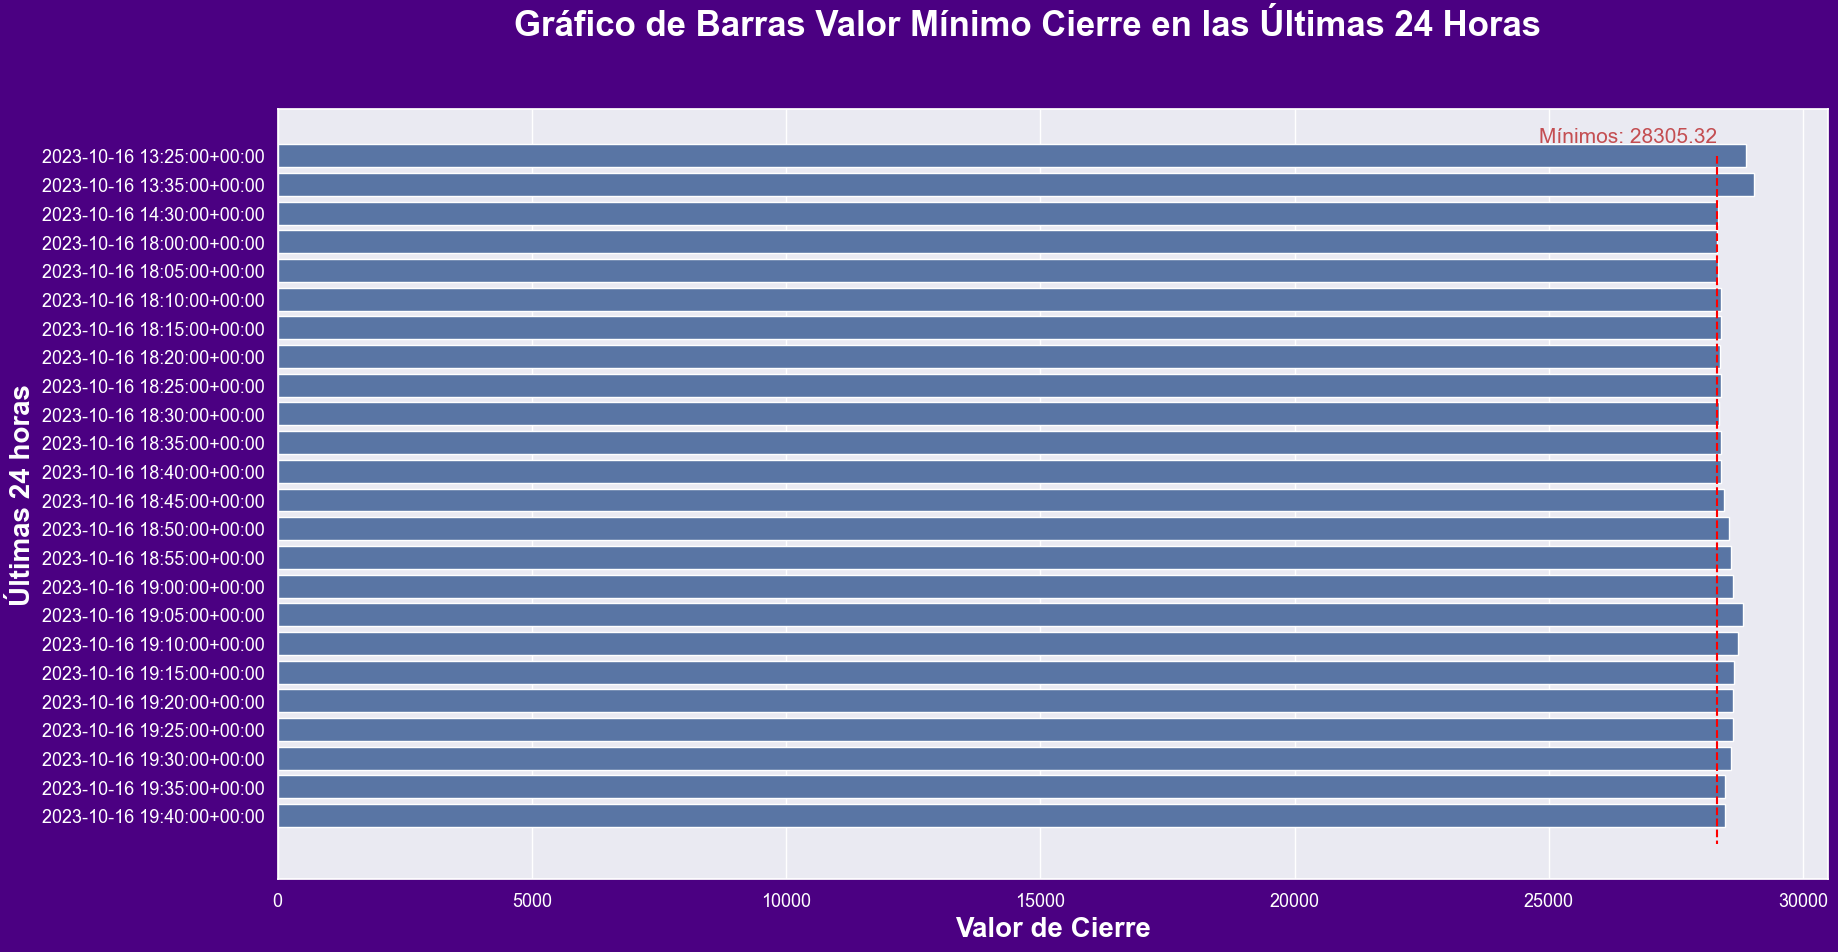

In [12]:
plt.figure(figsize=(20, 10), facecolor='indigo')
datos_limpios = limpieza_datos()[0]
close = datos_limpios['Close']

# sns.set(style="darkgrid")
sns.barplot( data=datos_limpios.head(24), x='Close', y='Datetime');
plt.suptitle('Gráfico de Barras Valor Mínimo Cierre en las Últimas 24 Horas', color='w', fontsize=25, fontweight='bold')
plt.xlabel('Valor de Cierre',color='w', size=20, fontweight='bold')
plt.ylabel('Últimas 24 horas', color='w', size=20, fontweight='bold')
plt.tick_params(axis='x', colors='w', labelsize=13)
plt.tick_params(axis='y', colors='w',labelsize=13)
maximos = round(datos_limpios.head(24)[datos_limpios.head(24)['Close'] == datos_limpios.head(24)['Close'].min()], 2)
plt.vlines(x=maximos['Close'], ymin=0, ymax=len(datos_limpios.head(24)), colors='red', linestyles='dashed', label='Mínimos')
for index, row in maximos.iterrows():
    plt.text(row['Close'], len(datos_limpios.head(24)) - 25, f'Mínimos: {row["Close"]}', fontsize=15, ha='right', va='top', color='r')
plt.gray()
plt.show()

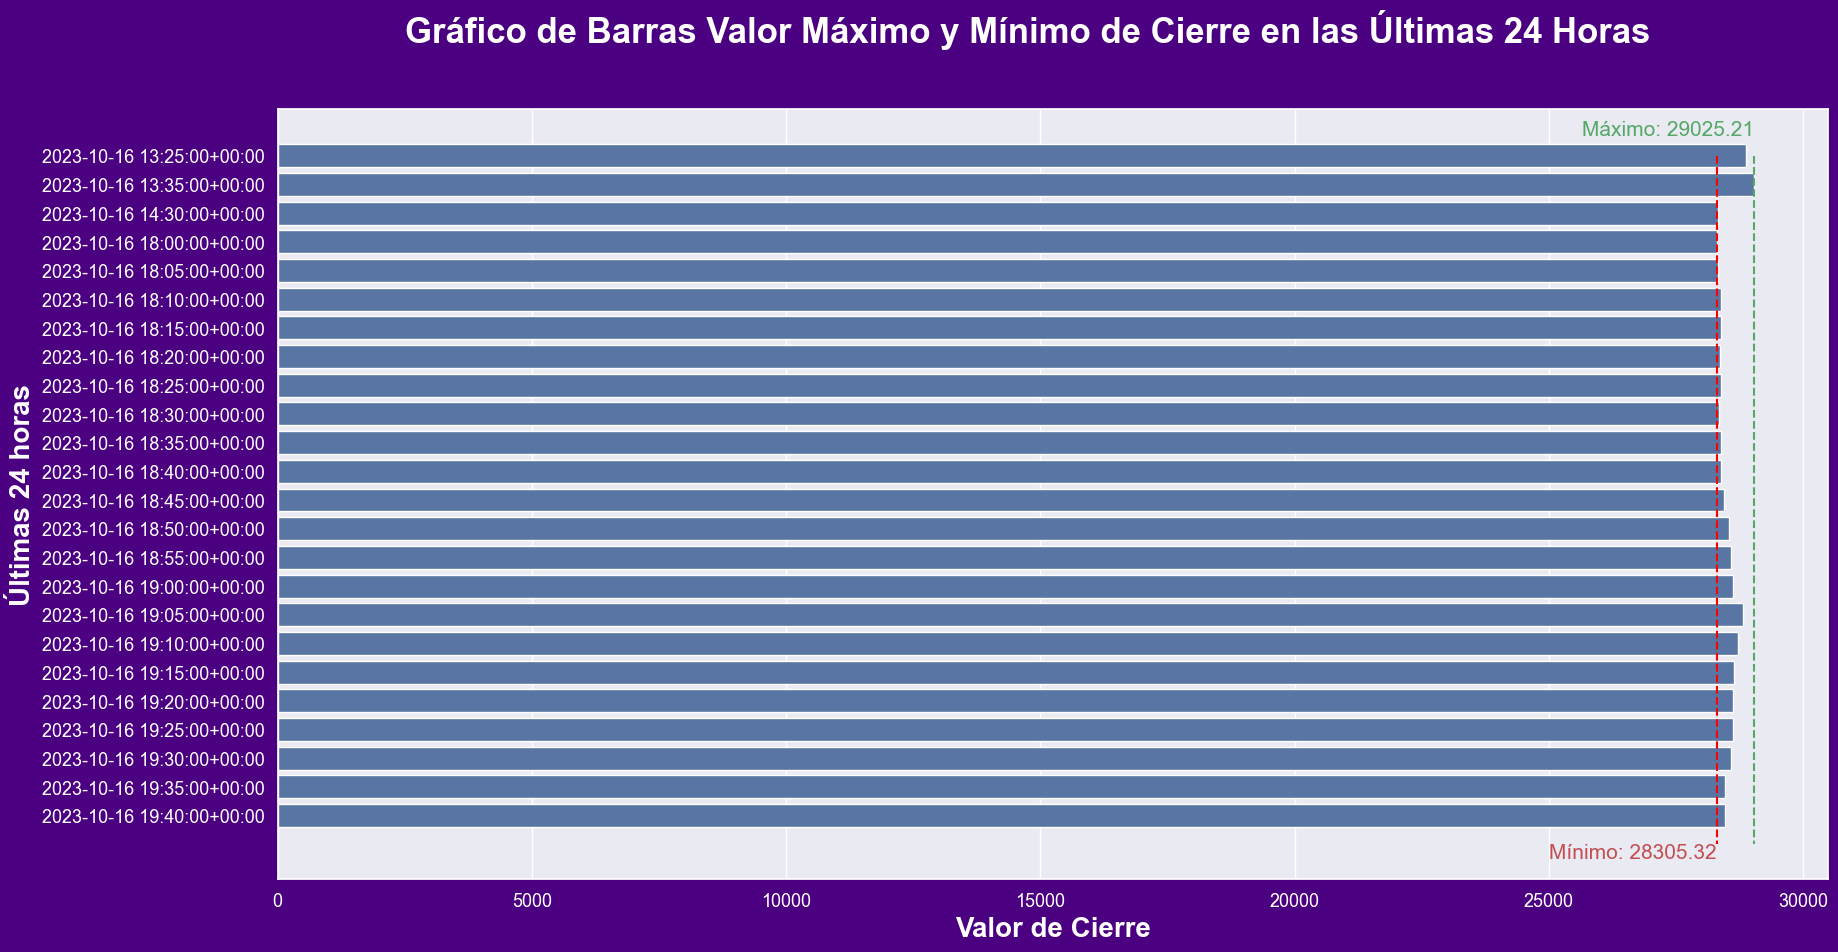

In [13]:
plt.figure(figsize=(20, 10), facecolor='indigo')
datos_limpios = limpieza_datos()[0]
close = datos_limpios['Close']
sns.barplot( data=datos_limpios.head(24), x='Close', y='Datetime');
plt.suptitle('Gráfico de Barras Valor Máximo y Mínimo de Cierre en las Últimas 24 Horas', color='w', fontsize=25, fontweight='bold')
plt.xlabel('Valor de Cierre',color='w', size=20, fontweight='bold')
plt.ylabel('Últimas 24 horas', color='w', size=20, fontweight='bold')
plt.tick_params(axis='x', colors='w', labelsize=13)
plt.tick_params(axis='y', colors='w',labelsize=13)

maximo = round(datos_limpios.head(24)['Close'].max(), 2)
minimo = round(datos_limpios.head(24)['Close'].min(), 2)

plt.vlines(x=maximo, ymin=0, ymax=len(datos_limpios.head(24)), colors='g', linestyles='dashed', label='Máximos')
plt.vlines(x=minimo, ymin=0, ymax=len(datos_limpios.head(24)), colors='red', linestyles='dashed', label='Mínimos')

plt.text(maximo, len(datos_limpios.head(24)) - 25.25, f'Máximo: {maximo}', fontsize=15, ha='right', va='top', color='g')
plt.text(minimo, len(datos_limpios.head(24)) - 0.05, f'Mínimo: {minimo}', fontsize=15, ha='right', va='top', color='r')

plt.gray()
plt.show()


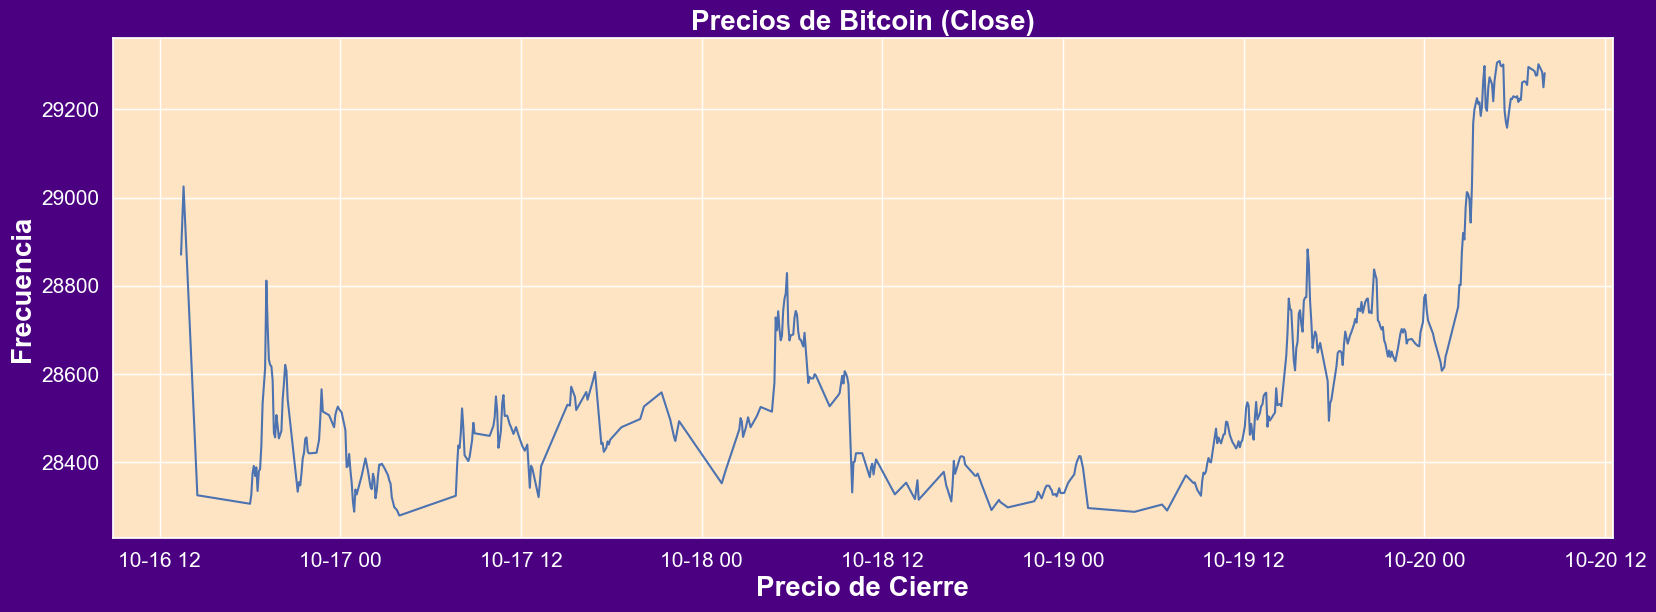

In [14]:
# sns.set(style="darkgrid")
fig = plt.figure(figsize=(15,5), facecolor='indigo')
eje = fig.add_axes([0,0,1,1])
eje.tick_params(axis='x', colors='w', labelsize=15)
eje.tick_params(axis='y', colors='w', labelsize=15)

datos_limpios = limpieza_datos()[0]
close = datos_limpios['Close']

eje.plot(close)
eje.set_title('Precios de Bitcoin (Close)', fontsize=20, fontweight='bold', color='w')
eje.set_xlabel('Precio de Cierre', fontsize=20, fontweight='bold', color='w')
eje.set_ylabel('Frecuencia', fontsize=20, fontweight='bold', color='w')
eje.set_facecolor('bisque')
plt.gray()
plt.show()

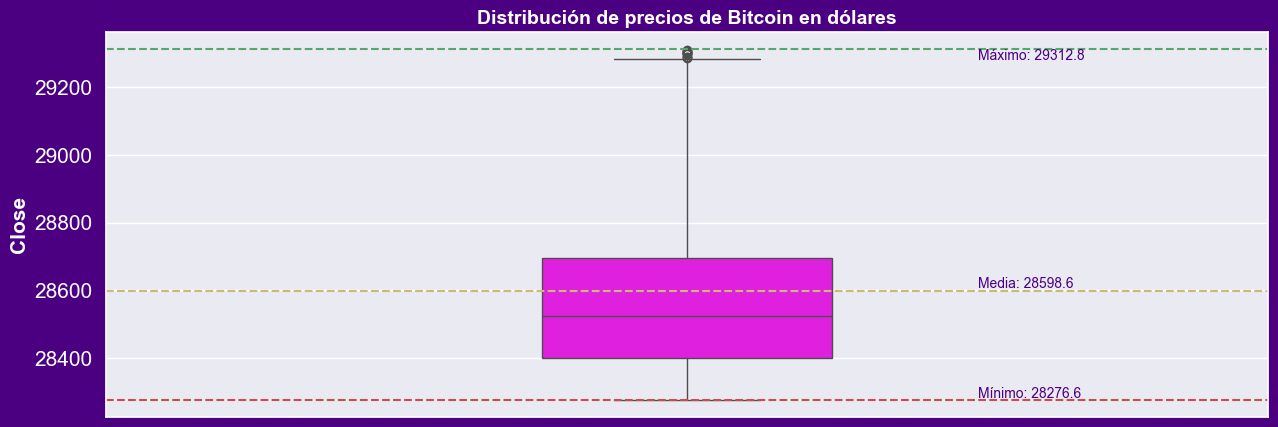

In [15]:
def boxplot1():
  # sns.set(style="darkgrid")
  plt.figure(figsize=(15, 5), facecolor='indigo')
  plt.tick_params(axis='x', colors='w', labelsize=15)
  plt.tick_params(axis='y', colors='w', labelsize=15)
 
  boxplot = sns.boxplot(y='Close', data=df_bitcoin_limpio, color='magenta', whis=2, width=0.25)
  plt.ylabel('Close', fontsize=15, color='w', fontweight='bold')
  plt.title('Distribución de precios de Bitcoin en dólares', fontsize=14, color='w',fontweight='bold')

  media = df_bitcoin_limpio['Close'].mean()
  maximo = limpieza_datos()[2]
  minimo = limpieza_datos()[1]

  boxplot.axhline(y=maximo, color='g', linestyle='--')
  boxplot.axhline(y=media, color='y', linestyle='--') 
  boxplot.axhline(y=minimo, color='r', linestyle='--') 
  
  plt.text(x=0.25, y=limpieza_datos()[2], s=f'Máximo: {limpieza_datos()[2].round(1)}', fontsize=10, va='top', color='indigo')
  plt.text(x=0.25, y=media, s=f'Media: {media.round(1)}', fontsize=10, va='bottom', color='indigo')
  plt.text(x=0.25, y=limpieza_datos()[1], s=f'Mínimo: {limpieza_datos()[1].round(1)}', fontsize=10, va='bottom', color='indigo')
  plt.gray()
  return plt.show()

boxplot1()

4.Toma de desición Compra / Vanta / Espera

In [17]:
def tomar_decisiones():
  global df_bitcoin, precio_actual, media_bitcoin, algoritmo_decision, df_bitcoin_limpio
  media_bitcoin = df_bitcoin_limpio['Close'].mean()
  if ((precio_actual >= media_bitcoin) & (tendencia == 'baja')):
    algoritmo_decision = 'Vender--'
  elif ((precio_actual < media_bitcoin) & (tendencia == 'alta')):
    algoritmo_decision = 'Comprar--'
  else:
    algoritmo_decision = 'Esperar--'

  return algoritmo_decision

tomar_decisiones()

'Esperar--'

5.Visualizando los datos / Variación de los últimos 7 días

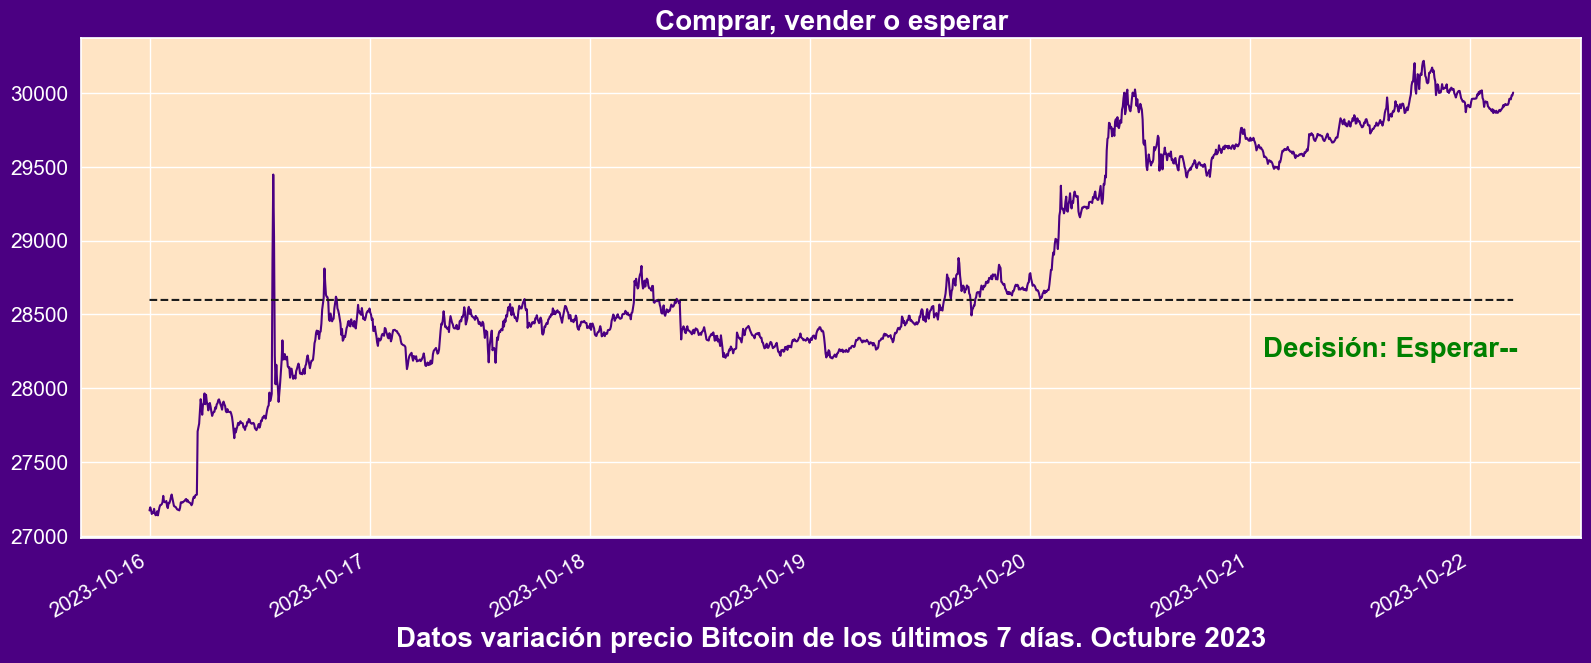

In [18]:
def visualizacion():
  global df_bitcoin, precio_actual, tendencia, media_bitcoin, algoritmo_decision, df_bitcoin_limpio
  df_bitcoin['Promedio'] = media_bitcoin

  # sns.set(style="whitegrid")
  fig = plt.figure(figsize=(15,5), facecolor='indigo')
  eje = fig.add_axes([0,0,1,1])
  eje.tick_params(axis='x', colors='w', labelsize=15)
  eje.tick_params(axis='y', colors='w', labelsize=15)
  
  eje.set_title('Comprar, vender o esperar', fontsize=20,fontweight='bold', color='w')
  df_bitcoin['Close'].plot(legend = None, color = 'indigo')
  df_bitcoin['Promedio'].plot(legend = None, ls='--', color = 'k', fontsize=15)
  

  eje.set_xlabel('Datos variación precio Bitcoin de los últimos 7 días. Octubre 2023', fontsize=20, fontweight='bold', color='w')
  eje.set_facecolor('bisque')
  eje.annotate(f'Decisión: {algoritmo_decision}', xy=(df_bitcoin.index[-1], df_bitcoin['Close'].iloc[-1]), xytext=(-180, -190), textcoords='offset points', fontsize=20, color='green',fontweight='bold')
  plt.gray()
  plt.show()
  
visualizacion()

6.Automatizamos el sistema 

Hora de verificación: 01:47:31
Ejecuciones: 1
Decisión: Esperar--
Tendencia: alta
Media: 28598
Precio: 29986


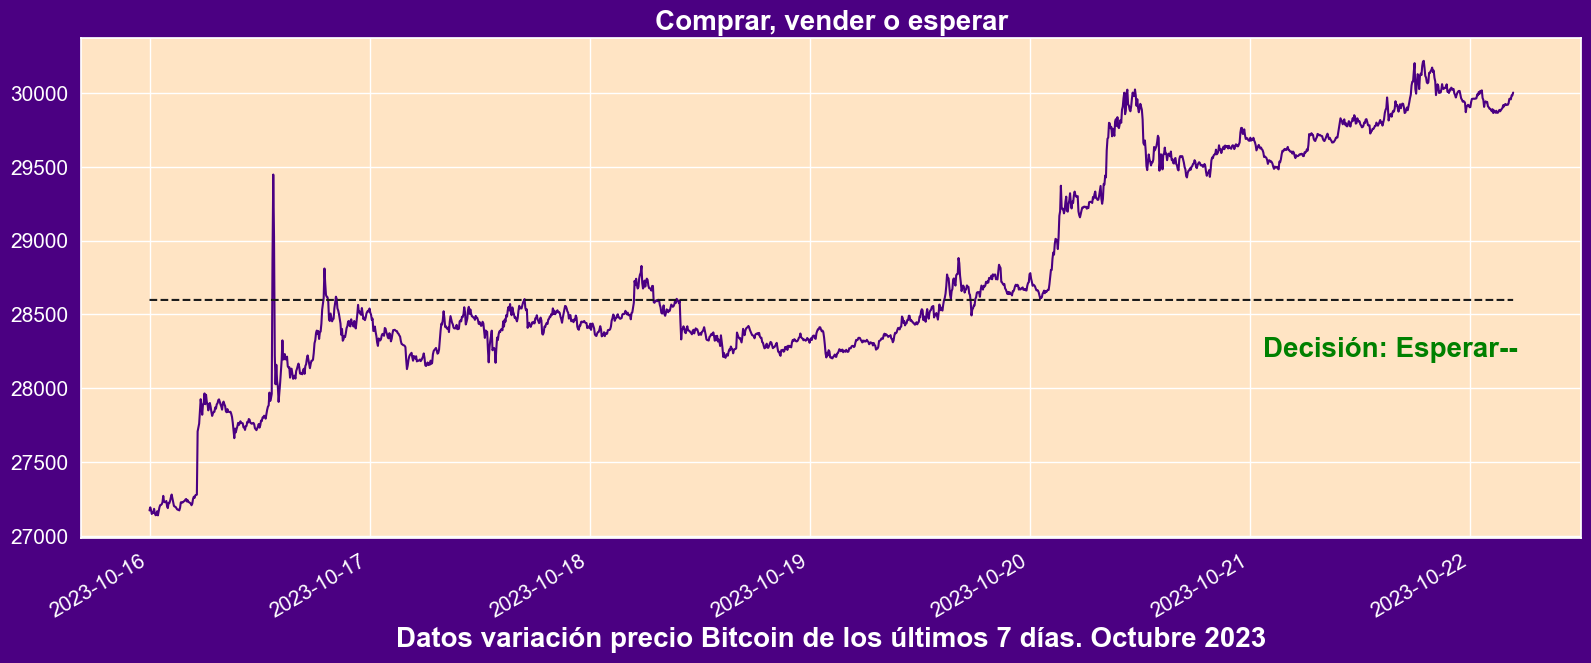

In [19]:
  
def automatizado(): 
  contador = 0 
  while True:
    contador += 1
    clear_output(wait=True)
    importar_base_bitcoin()
    extraer_tendencias()
    limpieza_datos()
    tomar_decisiones()
    tz = pytz.timezone('America/Argentina/Buenos_Aires')
    now = datetime.datetime.now(tz)
    print("Hora de verificación:", now.strftime("%H:%M:%S"))
    print(f'Ejecuciones: {contador}')
    print('Decisión:', tomar_decisiones()),print('Tendencia:',tendencia),print('Media:',int(media_bitcoin)),print('Precio:',int(precio_actual))
    visualizacion()
    time.sleep(300)
    
    
    
automatizado()
  
  


La toma de datos de variación de precio del bitcoin de los últimos 7 días es un proceso que consiste en recopilar información sobre el precio del bitcoin en un período de tiempo determinado. Esta información se puede utilizar para realizar análisis de tendencias y proyecciones del precio futuro de la moneda.
En nuestro caso para la toma de desiciones de Compra / Venta / Espera según situación y conveniencia.
Web scraping: Este método permite extraer datos de una página web utilizando un script o programa.
Una vez que se han recopilado los datos, se pueden almacenar en una base de datos o en un archivo CSV. Los datos se pueden analizar utilizando una variedad de herramientas y técnicas, como hojas de cálculo, software de análisis de datos y lenguajes de programación.
Una vez que se han recopilado los datos, se pueden analizar para obtener información sobre la variación de precio del bitcoin de los últimos 7 días. Por ejemplo, se puede calcular el rendimiento diario del bitcoin o el porcentaje de variación de precio del bitcoin en un período de tiempo determinado.